In [29]:
%cd /qbio/ari/works/SCV2_2022_re

/qbio/ari/works/SCV2_2022_re


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

matplotlib.rcParams['ytick.labelright'] = True
matplotlib.rcParams['ytick.labelleft'] = False
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.left'] = False

In [31]:
orfcolors = {'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [32]:
anno = pd.read_csv('hy_/refs/SARS-CoV-2-annotations.gff'
                   , sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z'])
cdsanno = anno[anno['type'] == 'CDS']
cdsanno = cdsanno.iloc[:10].sort_values(by='start').iloc[:9]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 266, 13468, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13468, 21552, '.', '.', '.'], index=cdsanno.columns),
    ])])
cdsanno = cdsanno.sort_values(by='start').iloc[:, 2:5].reset_index(drop=True)
cdsanno['color'] = cdsanno['name'].apply(orfcolors.__getitem__)
#cdsanno.to_pickle('tmp/cdsannotation.pickle')
cdsanno

from Bio import Seq
from Bio import SeqIO

reference_sequence = 'hy_/refs/SARS-CoV-2-RNA.fa'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [33]:
SAMPLES_ALL = 'Korea_2020 Freiburg_2020_1 IVT_1 IVT_2'.split(' ')
SAMPLES_VIRAL = 'Korea_2020 Freiburg_2020_1'.split(' ')
SAMPLES_CTL = 'IVT_1 IVT_2'.split(' ')


In [202]:
viral_colors = {'Korea_2020':'crimson',
                'Freiburg_2020_1':'dodgerblue',
               }
sample_anno = {'Korea_2020': 'Kim, 2020',
             'Freiburg_2020_1': 'Miladi, 2020',
              'IVT_1': 'IVT 1',
               'IVT_2': 'IVT 2'}

In [35]:
MIN_COV = 100
MIN_ODDR = 1.5
AGG_DIS = 4
MIN_MODFRAC = 0.2
MAX_PVALUE = 0.05

In [36]:
samples_cov = [pd.read_csv(f'stats/{name}.viral_linear.cov.txt', sep='\t',
                     names='chrom pos count'.split(' ')) for name in SAMPLES_ALL]
balanced_cov = [pd.read_csv(f'stats/{name}.balanced.cov.txt', sep='\t',
                     names='chrom pos count'.split(' ')) for name in SAMPLES_VIRAL]
subsampled_cov = [pd.read_csv(f'stats/{name}.subset.cov.txt', sep='\t',
                     names='chrom pos count'.split(' ')) for name in SAMPLES_CTL]

In [171]:
import matplotlib.patches as patches

/tmp/ipykernel_2835903/2200328410.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  shp = patches.Rectangle((x,y), width, height,


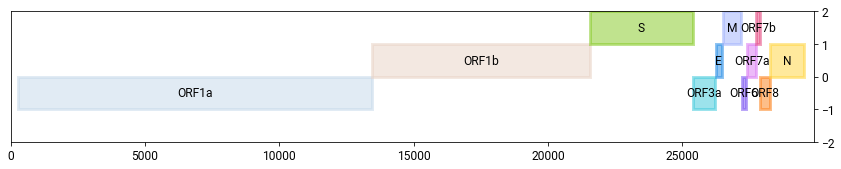

In [198]:
fig, ax = plt.subplots(1,1, figsize=(9.6*1.5, 2.4), facecolor='white')
ylist = [-1, 0, 1]
for _, row in cdsanno.iterrows():
    y = ylist[_%3]
    x = row['start']

    width = row['end']-row['start']
    height = 1
    shp = patches.Rectangle((x,y), width, height,
                           edgecolor=row['color'], linewidth=3,
                           fill=True, alpha=.5, color=row['color'])
    ax.add_patch(shp)
    
    x = (row['start']+row['end'])/2
    y = y+.5
    ax.text(x, y, row['name'],va='center', ha='center')

ax.set_xlim(0, len(refseq))
ax.set_ylim(-2, 2)
fig.savefig('figfinal/SCV2_ORFs.pdf')

In [190]:
cdsanno

,name,start,end,color
0,ORF1a,266,13468,#c5d9ea
1,ORF1b,13468,21552,#e8d2c4
2,S,21563,25384,#82c91e
3,ORF3a,25393,26220,#3bc9db
4,E,26245,26472,#228be6
5,M,26523,27191,#9fb1fc
6,ORF6,27202,27387,#7950f2
7,ORF7a,27394,27759,#da77f2
8,ORF7b,27756,27887,#e64980
9,ORF8,27894,28259,#fd7e14


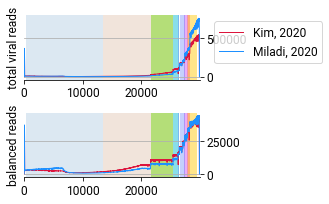

In [204]:
STRIDESIZE = 10
fig, axes = plt.subplots(2,1, facecolor='white', figsize=(4.8,5.76/2))

for i, name in enumerate(SAMPLES_VIRAL):
    ax = axes[0]
    data= samples_cov[i]
    data['binpos'] = np.floor(data['pos']/STRIDESIZE).astype(int) * STRIDESIZE
    medcov_ = data.groupby('binpos').agg({'count': 'median'})
    medcov_ = medcov_.fillna(0)
    medcov_['count'] = medcov_['count']
    ax.plot(medcov_.index, medcov_['count'].tolist(), lw=1,
           label=sample_anno[name], c=viral_colors[name])
    
    ax = axes[1]
    data= balanced_cov[i]
    data['binpos'] = np.floor(data['pos']/STRIDESIZE).astype(int) * STRIDESIZE
    medcov_ = data.groupby('binpos').agg({'count': 'median'})
    medcov_ = medcov_.fillna(0)
    medcov_['count'] = medcov_['count']
    ax.plot(medcov_.index, medcov_['count'].tolist(), lw=1,
           label=sample_anno[name], c=viral_colors[name])
for ax in axes:
    
    ax.set_xlim(0, len(refseq))
    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.6, zorder=0)
    
    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)
axes[0].set_ylabel('total viral reads')
axes[1].set_ylabel('balanced reads')
axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#axes[0].set_ylim(0, 12000)
#axes[1].set_ylim(0, 12000)
#plt.savefig('figoutput/total_coverage_12000.pdf')
plt.tight_layout()
plt.savefig('figfinal/total_coverage.pdf')

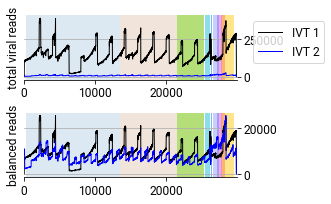

In [203]:
STRIDESIZE = 10
fig, axes = plt.subplots(2,1, facecolor='white', figsize=(9.6/2,5.76/2))

c = 'black blue'.split(' ')
for i, name in enumerate(SAMPLES_CTL):
    ax = axes[0]
    data= samples_cov[i+2]
    data['binpos'] = np.floor(data['pos']/STRIDESIZE).astype(int) * STRIDESIZE
    medcov_ = data.groupby('binpos').agg({'count': 'median'})
    medcov_ = medcov_.fillna(0)
    medcov_['count'] = medcov_['count']
    ax.plot(medcov_.index, medcov_['count'].tolist(), lw=1,
           label=sample_anno[name], c=c[i])
    
    ax = axes[1]
    data= subsampled_cov[i]
    data['binpos'] = np.floor(data['pos']/STRIDESIZE).astype(int) * STRIDESIZE
    medcov_ = data.groupby('binpos').agg({'count': 'median'})
    medcov_ = medcov_.fillna(0)
    medcov_['count'] = medcov_['count']
    ax.plot(medcov_.index, medcov_['count'].tolist(), lw=1,
           label=sample_anno[name], c=c[i])
for ax in axes:
    
    ax.set_xlim(0, len(refseq))
    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.6, zorder=0)
    
    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)
axes[0].set_ylabel('total viral reads')
axes[1].set_ylabel('balanced reads')
axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#axes[0].set_ylim(0, 12000)
#axes[1].set_ylim(0, 12000)
#plt.savefig('figoutput/total_coverage_12000.pdf')
plt.tight_layout()
plt.savefig('figfinal/IVT_coverage.pdf')

In [77]:
countdf = pd.DataFrame({'total': {'Korea_2020': 879679,
  'Freiburg_2020_1': 1382891,
  'IVT_1': 3460914,
  'IVT_2': 197347},
 'unmapped': {'Korea_2020': 41453,
  'Freiburg_2020_1': 66212,
  'IVT_1': 188899,
  'IVT_2': 19000},
 'RCS': {'Korea_2020': 61676,
  'Freiburg_2020_1': 18097,
  'IVT_1': 85309,
  'IVT_2': 3130},
 'virus': {'Korea_2020': 575309,
  'Freiburg_2020_1': 804707,
  'IVT_1': 3189278,
  'IVT_2': 175157},
  'host': {'Korea_2020': 201241,
  'Freiburg_2020_1': 493875,
  'IVT_1': 0,
  'IVT_2': 60}}
)

countdf

,total,unmapped,RCS,virus,host
Korea_2020,879679,41453,61676,575309,201241
Freiburg_2020_1,1382891,66212,18097,804707,493875
IVT_1,3460914,188899,85309,3189278,0
IVT_2,197347,19000,3130,175157,60


In [78]:
countdf_ = countdf.copy()
countdf_['unmapped'] = countdf['unmapped']*100/countdf['total']
countdf_['RCS'] = countdf['RCS']*100/countdf['total']
countdf_['virus'] = countdf['virus']*100/countdf['total']
countdf_['host'] = countdf['host']*100/countdf['total']

countdf_['total'] = 100
countdf_

,total,unmapped,RCS,virus,host
Korea_2020,100,4.712287,7.011194,65.399879,22.876640
Freiburg_2020_1,100,4.787941,1.308635,58.190197,35.713227
IVT_1,100,5.458067,2.464927,92.151322,0.000000
IVT_2,100,9.627712,1.586039,88.755846,0.030403


In [79]:
import seaborn as sns

/tmp/ipykernel_2835903/2635484502.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


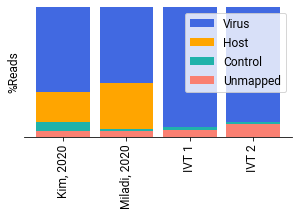

In [205]:

labels = SAMPLES_ALL
unmapped = countdf_['unmapped']
RCS = unmapped+countdf_['RCS']
host = RCS+countdf_['host']
virus = host+countdf_['virus']


width = 0.85

fig, ax = plt.subplots(figsize=(4.8, 2.4))

ax.bar(labels, virus, width, label='Virus', color=['royalblue'])
ax.bar(labels, host, width, label='Host', color=['orange'])
ax.bar(labels, RCS, width,
       label='Control', color=['lightseagreen'])
ax.bar(labels, unmapped, width, label='Unmapped',
      color=['salmon'])


ax.set_ylabel('%Reads')

ax.legend()
ax.set_ylim(0,100)
ax.set_yticks([])
for spside in 'top left right'.split():
    plt.setp(ax.spines[spside], visible=False)
#ax.grid(True, zorder=0)
plt.setp(ax.get_xgridlines(), visible=False)

ax.set_xticklabels(
    sample_anno.values()
)
plt.xticks(rotation=90
          )
plt.savefig('figfinal/alnstat.pdf')

In [59]:
seqsum = []
for name in SAMPLES_VIRAL:
    summ = pd.read_csv(f'guppy_6.1.2/{name}/sequencing_summary.txt',
                      sep='\t')
    summ['sample'] = name
    seqsum.append(summ)
seqsum = pd.concat(seqsum)

In [60]:
viral_colors = {'Korea_2020':'crimson',
                'Freiburg_2020_1':'dodgerblue'}

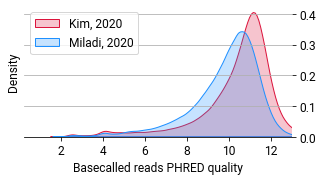

In [208]:
fig, ax = plt.subplots(figsize=(4.8, 2.4))
for k, v in viral_colors.items():
    summ = seqsum[seqsum['sample']==k]
    sns.kdeplot(summ['mean_qscore_template'], color=viral_colors[k],
               fill=True, label=sample_anno[k])
ax.set_xlim(0.25, 13)
for spside in 'top left right'.split():
    plt.setp(ax.spines[spside], visible=False)
ax.legend(loc='upper left')
ax.grid(True)
plt.setp(ax.get_xgridlines(), visible=False)
ax.set_xlabel('Basecalled reads PHRED quality')
ax.set_ylabel('Density')
fig.savefig('figfinal/qscore.pdf', bbox_inches='tight')

In [90]:
SAMPLES_VIRAL

['Korea_2020', 'Freiburg_2020_1']

In [91]:
onteligos = []
for i, file in enumerate(['eligos2/pairdiff/RCS/Korea_2020/Korea_2020.genome.sorted_vs_IVT_1.genome.sorted_on_ont-refs_combine.txt',
            'eligos2/pairdiff/RCS/Korea_2020/Korea_2020.genome.sorted_vs_IVT_2.genome.sorted_on_ont-refs_combine.txt',
            'eligos2/pairdiff/RCS/Freiburg_2020_1/Freiburg_2020_1.genome.sorted_vs_IVT_1.genome.sorted_on_ont-refs_combine.txt',
            'eligos2/pairdiff/RCS/Freiburg_2020_1/Freiburg_2020_1.genome.sorted_vs_IVT_2.genome.sorted_on_ont-refs_combine.txt']):
    file = pd.read_csv(file, sep='\t')
    name = i//2
    file['name'] = SAMPLES_VIRAL[name]
    onteligos.append(file)
onteligos = pd.concat(onteligos).reset_index(drop=True)

In [127]:
MIN_COV = 500
MIN_ODDR = 2.5
AGG_DIS = 4
MIN_MODFRAC = 0.2
MAX_PVALUE = 0.05

class eligos2:
    
    def __init__(self, filelist, samples):
        self.filelist = filelist
        self.samples = samples
        self.max_distance = 4
        self.minimum_coverage = MIN_COV
    
    def load_combine_all(self):
        modfracs = []
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            stats['sample'] = name
            modfracs.append(stats)

        modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
        modfracs = modfracs.reset_index(drop=True)
        return(modfracs)

    def get_modified_sites(self, pvalue=0.05, hp_filter=True):
        positive_positions = set()
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            if hp_filter:
                stats = stats[stats['homo_seq']=='--']

            stats_high = stats[(stats['test_cor_1']+stats['test_err_1']>= MIN_COV) &
                               (stats['ctrl_cor_1']+stats['ctrl_err_1']>= MIN_COV) &
                                   (stats['oddR'] >= MIN_ODDR) &
                              (stats['adjPval']<=MAX_PVALUE)&
                              (stats['ESB_test']>=0.01)]
            positive_positions |= set(stats_high['end_loc'].tolist())

        modfracs=[]
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            stats['sample'] = name
            modfracs.append(stats[stats['end_loc'].isin(positive_positions)])


        if len(modfracs) > 0:
            ret = pd.concat(modfracs).sort_values(by=['end_loc', 'sample']).reset_index(drop=True)
            return ret

    def aggregate_adjacent_sites(self, modfracs):

        modsites_raw = sorted(modfracs['end_loc'].unique())
        continuity = np.diff(modsites_raw) <= self.max_distance
        
        modsite_groups = [[modsites_raw.pop(0)]]
        for pos, cont in zip(modsites_raw, continuity):
            if cont:
                modsite_groups[-1].append(pos)
            else:
                modsite_groups.append([pos])

        purified = []
        for modsites in modsite_groups:
            modfracsites = modfracs[modfracs['end_loc'].isin(modsites)]

            modfracsites_high = modfracsites[modfracsites['total_reads'] >= self.minimum_coverage]
            maxpos = modfracsites.loc[modfracsites_high['oddR'].idxmax()]
            purified.append(modfracsites[modfracsites['end_loc'] == maxpos['end_loc']])

        return pd.concat(purified)
    
    def summarize_into_table(self, aggrtbl):
        mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['oddR'],
                                     index=['end_loc', 'strand'])['oddR'].copy()
        coverage = pd.pivot_table(aggrtbl, columns='sample', values=['total_reads'],
                                 index=['end_loc', 'strand'])['total_reads'].copy()
        esb = pd.pivot_table(aggrtbl, columns='sample', values=['ESB_test'],
                                 index=['end_loc', 'strand'])['ESB_test'].copy()
        return esb, mod_frac_all, coverage


def add_context_info(sitemodfrac, refseq, flanksize):
    context_list=[]
    for pos, strand in sitemodfrac.index:
        pos = pos -1 # one based in end_loc
        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        if strand =='-':
            context = str(Seq.Seq(context).reverse_complement())
        else:
            context = context
        context_list.append(context)
        
    return(context_list)


eligos2_analysis = eligos2([f'eligos2/pairdiff/{name}/combine.txt' for name in SAMPLES_VIRAL],
              SAMPLES_VIRAL)
eligos2_modfracs = eligos2_analysis.load_combine_all()

eligos2_freqmods = eligos2_analysis.get_modified_sites()
eligos2_psites = eligos2_analysis.aggregate_adjacent_sites(eligos2_freqmods)

eligos2_esb, eligos2_sitemodfrac, eligos2_sitecov= eligos2_analysis.summarize_into_table(eligos2_psites)

eligos2_sitemodfrac['context'] = add_context_info(eligos2_sitemodfrac, refseq, 10)

eligos2_sitemodfrac = eligos2_sitemodfrac.reset_index().set_index('end_loc')

/tmp/ipykernel_2835903/3383403775.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plotdf = eligos2_sitemodfrac[eligos2_sitemodfrac.max(axis=1)<=2**5]


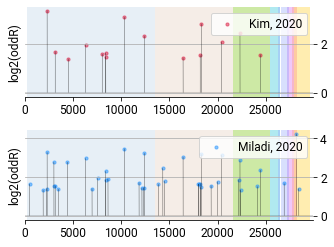

In [209]:
fig, axes = plt.subplots(2,1, facecolor='white', figsize=(4.8, 3.6))
plotdf = eligos2_sitemodfrac[eligos2_sitemodfrac.max(axis=1)<=2**5]
for i, name in enumerate(SAMPLES_VIRAL):
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = plotdf[plotdf[name]>=MIN_ODDR]
    plot_y[tempfrac[name].index] = np.log2(tempfrac[name])
    
    axes[i].scatter(tempfrac.index, np.log2(tempfrac[name]), color=viral_colors[name],
                alpha=.5, s=10, label=sample_anno[name])
    
    axes[i].plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
    
for ax in axes:
#ax.legend()
    ax.set_xlim(0, len(refseq))
    ax.set_ylabel('log2(oddR)')


    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)

    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
    ax.legend(loc='upper right')
plt.tight_layout()
fig.savefig('figfinal/eligos2_output.pdf')

In [136]:
eligos2_site

sample,strand,Freiburg_2020_1,Korea_2020,context
end_loc,,,,
521,+,3.131621,0.642057,ucauguuaugGuugagcuggu
1911,+,2.514396,0.996207,ucaauuuucuCccgcacucuu
2272,+,2.640272,1.812861,ccugugcaaaGgaaauuaagg
2326,+,9.735174,10.227492,aauuuuuggcUuugugugcug
3037,+,6.836818,0.808610,auuguucuuuCuacccuccag
3045,+,2.947950,0.940003,uucuacccucCagaugaggau
3160,+,2.912337,3.199045,uuggugccacUucugcugcuc
3487,+,2.598430,0.850827,uugcaggagcCuuaaauaagg
4402,+,198.105436,0.724253,gagaaaugcuCgcacaugcag


/tmp/ipykernel_2835903/1649289567.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tempfrac = eligos2_sitemodfrac[eligos2_sitemodfrac.max(axis=1)<=2**5]
/blaze/ari/conda/envs/lab/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2835903/1649289567.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tempfrac = eligos2_sitemodfrac[eligos2_sitemodfrac.max(axis=1)<=2**5]
/blaze/ari/conda/envs/lab/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufun

Text(0, 0.5, '-log10(pvalue)')

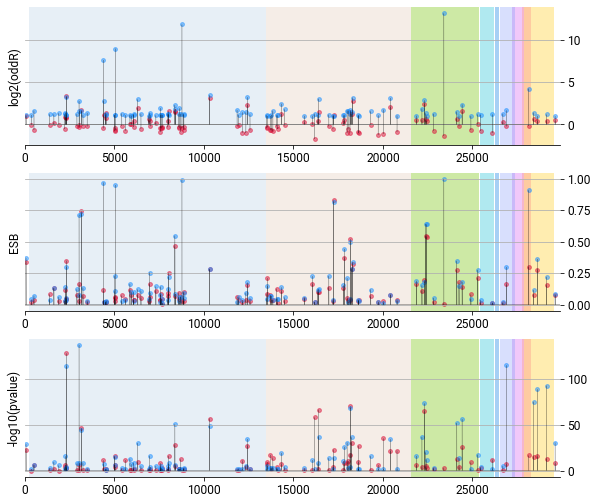

In [126]:
fig, axes = plt.subplots(3,1, facecolor='white', figsize=(9.6,2.88*3))
for name in SAMPLES_VIRAL:
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = eligos2_sitemodfrac[eligos2_sitemodfrac.max(axis=1)<=2**5]
    tempfrac= eligos2_sitemodfrac
    plot_y[tempfrac[name].index] = np.log2(tempfrac[name])
    ax = axes[0]
    ax.scatter(tempfrac.index, np.log2(tempfrac[name]), color=viral_colors[name],
                alpha=.5, s=15, label=name)
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
    
    
    ax = axes[1]
    tempfrac = eligos2_esb.reset_index().set_index('end_loc')
    #tempfrac = tempfrac[eligos2_sitemodfrac.max(axis=1)<2**5]
    plot_y[tempfrac[name].index] = (tempfrac[name])
    
    ax.scatter(tempfrac.index, (tempfrac[name]), color=viral_colors[name],
                alpha=.5, s=15, label=name)
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
    
    
    ax = axes[2]
    tempfrac = pd.pivot_table(eligos2_psites, columns = 'sample', values='adjPval',
               index='end_loc')
    #tempfrac = tempfrac[eligos2_sitemodfrac.max(axis=1)<2**5]
    plot_y[tempfrac[name].index] = -np.log10(tempfrac[name])
    
    ax.scatter(tempfrac.index, -np.log10(tempfrac[name]), color=viral_colors[name],
                alpha=.5, s=15, label=name)
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
#ax.legend()
for ax in axes:
    ax.set_xlim(0, len(refseq))
    
    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)

    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
axes[0].set_ylabel('log2(oddR)')
axes[1].set_ylabel('ESB')
axes[2].set_ylabel('-log10(pvalue)')

In [211]:
class m6anet:
    
    def __init__(self, filelist, samples, frp):
        self.filelist = filelist
        self.samples = samples
        self.max_distance = 4
        self.minimum_coverage = MIN_COV
        self.min_modfrac = frp
    
    def load_combine_all(self):
        modfracs = []
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats['sample'] = name
            modfracs.append(stats)
        modfracs = pd.concat(modfracs).sort_values(by=['transcript_id','transcript_position','sample'])
        modfracs.columns = 'chr pos cov probability sample'.split(' ')
        
        modfracs['pos'] +=1
        return(modfracs)

    def get_modified_sites(self, hp_filter=True):
        positive_positions = set()
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats.columns = 'chr pos cov probability'.split(' ')

        
            stats_high = stats[(stats['cov']>=self.minimum_coverage)&
                               (stats['probability']>=self.min_modfrac)]
            positive_positions |= set(stats_high['pos'].tolist())

        modfracs=[]
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = ',', compression='gzip')
            stats['sample'] = name
            stats.columns =  'chr pos cov probability sample'.split(' ')
            modfracs.append(stats[stats['pos'].isin(positive_positions)])


        if len(modfracs) > 0:
            ret = pd.concat(modfracs).sort_values(by=['pos', 'sample']).reset_index(drop=True)
            ret['pos'] +=1
            return ret

    def aggregate_adjacent_sites(self, modfracs):

        modsites_raw = sorted(modfracs['pos'].unique())
        continuity = np.diff(modsites_raw) <= self.max_distance
        
        modsite_groups = [[modsites_raw.pop(0)]]
        for pos, cont in zip(modsites_raw, continuity):
            if cont:
                modsite_groups[-1].append(pos)
            else:
                modsite_groups.append([pos])

        purified = []
        for modsites in modsite_groups:
            modfracsites = modfracs[modfracs['pos'].isin(modsites)]

            modfracsites_high = modfracsites[modfracsites['cov'] >= self.minimum_coverage]
            maxpos = modfracsites.loc[modfracsites_high['probability'].idxmax()]
            purified.append(modfracsites[modfracsites['pos'] == maxpos['pos']])

        return pd.concat(purified)
    
    def summarize_into_table(self, aggrtbl):
        mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['probability'],
                                     index=['pos'])['probability'].copy()
        coverage = pd.pivot_table(aggrtbl, columns='sample', values=['cov'],
                                 index=['pos'])['cov'].copy()

        return mod_frac_all, coverage


def add_context_info(sitemodfrac, refseq, flanksize):
    context_list=[]
    for pos in sitemodfrac.index:
        pos = pos -1 # one based in end_loc
        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        
        context_list.append(context)
        
    return(context_list)


m6anet_analysis = m6anet([f'm6anet/try2/{name}/data.result.csv.gz' for name in SAMPLES_ALL],
              SAMPLES_ALL,
             0.2)
m6anet_modfracs = m6anet_analysis.load_combine_all()


In [212]:
m6anet_sitemodfrac['IVT'] = (m6anet_sitemodfrac['IVT_1']+ m6anet_sitemodfrac['IVT_2'])/2

In [213]:
modfrac_pivot = m6anet_modfracs.pivot(index='pos', columns='sample', values='probability').fillna(0)
modfrac_pivot['IVT'] = (modfrac_pivot['IVT_1']+modfrac_pivot['IVT_2'])/2
modfrac_pivot_ = modfrac_pivot['Freiburg_2020_1 Korea_2020 IVT'.split(' ')]

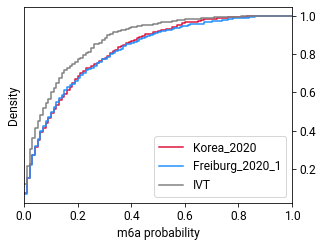

In [215]:
fig, ax = plt.subplots(1,1, figsize=(4.8, 3.6))

for i, name in enumerate('Korea_2020 Freiburg_2020_1 IVT'.split(' ')):
    tempplot = modfrac_pivot_[name]
    try:
        c = viral_colors[name]
    except:
        c = 'grey'
    try:
        label = sample_anno[name]
    except:
        label = name
    sns.histplot(tempplot, cumulative=True,
                bins=100, binrange=(0,1), element='step',
                fill=False, color=c,
              stat='density', label=name)

ax.set_xlim(0,  1)
#ax.axvline(frp, zorder=0, color='red', lw=1, alpha=.8)

ax.legend(loc='lower right')
ax.set_xlabel('m6a probability')
plt.savefig('figfinal/m6Aprob_curv.pdf')

In [164]:
frp = np.percentile(modfrac_pivot_['IVT'], 95)
frp

0.44500653599999973

In [165]:
m6anet_analysis = m6anet([f'm6anet/try2/{name}/data.result.csv.gz' for name in SAMPLES_ALL],
              SAMPLES_ALL,
             frp)
m6anet_modfracs = m6anet_analysis.load_combine_all()
m6anet_freqmods = m6anet_analysis.get_modified_sites()
m6anet_psites = m6anet_analysis.aggregate_adjacent_sites(m6anet_freqmods)

m6anet_sitemodfrac, m6anet_sitecov= m6anet_analysis.summarize_into_table(m6anet_psites)

m6anet_sitemodfrac['context'] = add_context_info(m6anet_sitemodfrac, refseq, 10)


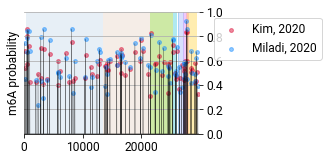

In [216]:
fig, ax = plt.subplots(1,1, facecolor='white', figsize=(4.8,2.4))

for sample in SAMPLES_VIRAL:
    
    name = sample
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = m6anet_sitemodfrac[m6anet_sitemodfrac[name]>=MIN_MODFRAC]

    plot_y[tempfrac[name].index] = tempfrac[name]
    
    ax.scatter(tempfrac.index, tempfrac[name],
                alpha=.5, s=15, label=sample_anno[name], c=viral_colors[name])
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
ax.set_xlim(0, len(refseq))
ax.legend()
ax.set_ylabel('m6A probability')


for spside in 'top left right'.split():
    plt.setp(ax.spines[spside], visible=False)

ax.grid(True)
plt.setp(ax.get_xgridlines(), visible=False)

for _, row in cdsanno.iterrows():
    ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
ax.set_ylim(0, 1)
plt.tight_layout()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig('figfinal/m6Anet_output.pdf')

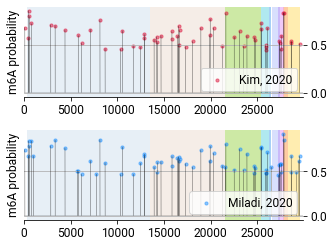

In [217]:
fig, axes = plt.subplots(2,1, facecolor='white', figsize=(4.8, 3.6))
plotdf = m6anet_sitemodfrac[m6anet_sitemodfrac[name]>=FRP]
for i, name in enumerate(SAMPLES_VIRAL):
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = plotdf[plotdf[name]>=FRP]
    plot_y[tempfrac[name].index] = tempfrac[name]
    
    axes[i].scatter(tempfrac.index, tempfrac[name], color=viral_colors[name],
                alpha=.5, s=10, label=sample_anno[name])
    
    axes[i].plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
    
for ax in axes:
#ax.legend()
    ax.set_xlim(0, len(refseq))
    ax.set_ylabel('m6A probability')


    for spside in 'top left right'.split():
        plt.setp(ax.spines[spside], visible=False)

    ax.grid(True)
    plt.setp(ax.get_xgridlines(), visible=False)

    for _, row in cdsanno.iterrows():
        ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
    ax.legend(loc='lower right')
plt.tight_layout()

plt.savefig('figfinal/m6Anet_output_v2.pdf')

The output directory 'meme_m6anet/' already exists.
Its contents will be overwritten.
CD: cefrac 0.25 length 21 central region 4
BACKGROUND: using background model of order 0
PRIMARY (cd): n 85 p0 42 p1 21 p2 22
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p1; pvalue: p2; nsites: p0,p1,p2
Option '-maxw' is greather than the length of longest sequence (21).  Setting '-maxw' to 21.
SEEDS: maxwords 1785 highwater mark: seq 85 pos 13
BALANCE: samples 85 chars 1785 nodes 1 chars/node 1785

seqs=    85, min_w=  21, max_w=   21, total_size=     1785

motif=1
SEED DEPTHS: 2 4 8 16 32 42
SEED WIDTHS: 8 11 15 21
em: w=  11, psites=  42, iter=   0 



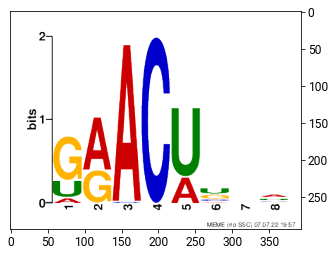

In [168]:
meme(m6anet_sitemodfrac)
!conda run -n meme meme temp_fasta.fa -oc meme_m6anet/ -rna  -objfun cd -mod zoops

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('meme_m6anet/logo1.png')
imgplot = plt.imshow(img)